In [1]:
import pandas as pd

In [2]:
# 1. Logistic Regression
from sklearn.linear_model import LogisticRegression

# 2. Decision Tree
from sklearn.tree import DecisionTreeClassifier

# 3. Random Forest
from sklearn.ensemble import RandomForestClassifier

# 4. XGBoost
from xgboost import XGBClassifier

# 5. LightGBM
from lightgbm import LGBMClassifier

# 성능평가 지표
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

# k-fold
from sklearn.model_selection import KFold

# pipeline
from sklearn.pipeline import make_pipeline

# 성능 튜닝
from sklearn.model_selection import cross_val_score, GridSearchCV

# 시각화
import matplotlib.pyplot as plt

#### 데이터 불러오기

In [38]:
data = pd.read_csv('./data_eda02_final.csv')

- lightgbm에서, Do not support special JSON characters in feature name. 해당 문제 때문에 column이름을 변경하는 작업을 거치겠다.

In [39]:
data.columns

Index(['Unnamed: 0', 'url_len', 'url_num_hyphens_dom', 'url_path_len',
       'url_domain_len', 'url_num_dots', 'url_ip_present', 'url_entropy',
       'html_num_tags('script')', 'html_num_tags('div')',
       'html_num_tags('form')', 'html_num_tags('a')', 'label'],
      dtype='object')

In [40]:
data.rename(columns={
    'html_num_tags(\'script\')': 'tags_script',
    'html_num_tags(\'div\')' : 'tags_div',
    'html_num_tags(\'form\')' : 'tags_form',
    'html_num_tags(\'a\')' : 'tags_a'
}, inplace=True)

In [41]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [42]:
# 1. x, y 데이터 분리
target = 'label'
x = data.drop(target, axis=1)
y = data.loc[: , target]

x.shape, y.shape

((1239, 11), (1239,))

In [43]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2023)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((867, 11), (867,), (372, 11), (372,))

## Basic model

In [44]:
import warnings
warnings.filterwarnings('ignore')

#### 1) Logistic Regression

In [45]:
modelLr = LogisticRegression()
modelLr.fit(x_train, y_train)

LogisticRegression()

In [46]:
cv_score = cross_val_score(modelLr, x_train, y_train, cv=5, scoring='accuracy')
print(cv_score)
print(cv_score.mean())

[0.93678161 0.94252874 0.92485549 0.9132948  0.94219653]
0.931931433127367


In [47]:
result = {}
result['Logistic Regression'] = cv_score.mean()

### 2) Random Forest Classifier

In [48]:
modelRf = RandomForestClassifier()
modelRf.fit(x_train, y_train)
cv_score = cross_val_score(modelRf, x_train, y_train, cv=5, scoring='accuracy')
print(cv_score)
print(cv_score.mean())
result['Random Forest'] = cv_score.mean()

[0.94252874 0.95977011 0.94797688 0.98265896 0.97687861]
0.961962660288353


### 3) XGBOOST Classifier

In [49]:
modelXB = XGBClassifier()
modelXB.fit(x_train, y_train)
cv_score = cross_val_score(modelXB, x_train, y_train, cv=5, scoring='accuracy')
print(cv_score)
print(cv_score.mean())
result['XgBoost'] = cv_score.mean()

[0.97701149 0.95977011 0.95375723 0.95953757 0.95953757]
0.9619227958275198


### 4) LightGBM Classifier

In [50]:
modelGBM = LGBMClassifier()
modelGBM.fit(x_train, y_train)
cv_score = cross_val_score(modelGBM, x_train, y_train, cv=5, scoring='accuracy')
print(cv_score)
print(cv_score.mean())
result['LightGBM'] = cv_score.mean()

[0.95977011 0.96551724 0.95375723 0.98265896 0.97109827]
0.9665603614377783


### 5) Voting Classifier

In [51]:
from sklearn.ensemble import VotingClassifier
estimators = [('lr', LogisticRegression()),
              ('dt', DecisionTreeClassifier()),
              ('rdf', RandomForestClassifier()),
              ('xgb', XGBClassifier()),
              ('lgb', LGBMClassifier())]

modelVote = VotingClassifier(estimators=estimators)
modelVote.fit(x_train, y_train)

cv_score = cross_val_score(modelVote, x_train, y_train, cv=5, scoring='accuracy')
print(cv_score)
print('-'*80)
print(cv_score.mean())

[0.95977011 0.95977011 0.95953757 0.97109827 0.97109827]
--------------------------------------------------------------------------------
0.96425486678626


In [52]:
result['Voting'] = cv_score.mean()

#### 성능 비교

Logistic Regression 0.932
Random Forest 0.962
XgBoost 0.962
LightGBM 0.967
Voting 0.964


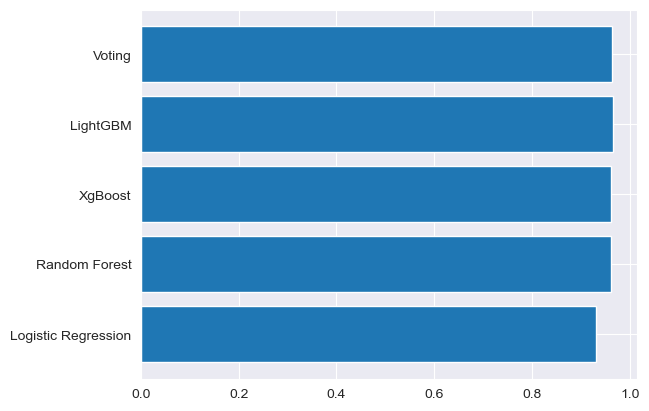

In [53]:
# 성능 비교
print('=' * 40)
for m_name, score in result.items():
    print(m_name, score.round(3))
print('=' * 40)

# 성능 시각화 비교
plt.barh(list(result.keys()), result.values())
plt.show()

- lightGBM의 성능이 가장 좋다. LightGBM > Voting > XGBoost == Random Forest > Logistic Regression

### 하이퍼 파라미터 튜닝

In [57]:
import numpy as np
from sklearn.model_selection import cross_val_score

hyper_params = {
    'learning_rate': (0.01, 0.5),
    'n_estimators': (100, 1000),
    'max_depth': (3, 10),
    'min_child_weight': (0, 10),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0)
    # 'reg_lambda': (0, 1000),
    # 'reg_alpha': (0, 1.0)
}

model = GridSearchCV(
    estimator=modelGBM,
    param_grid=hyper_params,
    cv=5,
    scoring='accuracy'
)

model.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(),
             param_grid={'colsample_bytree': (0.5, 1.0),
                         'learning_rate': (0.01, 0.5), 'max_depth': (3, 10),
                         'min_child_weight': (0, 10),
                         'n_estimators': (100, 1000), 'subsample': (0.5, 1.0)},
             scoring='accuracy')

In [58]:
print("최적 파라미터:", model.best_params_)
print("예측 최고 성능:", model.best_score_)

최적 파라미터: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 0, 'n_estimators': 1000, 'subsample': 0.5}
예측 최고 성능: 0.9700219254534582


In [59]:
result['hypertune_lightGBM'] = model.best_score_

#### 변수 중요도 시각화

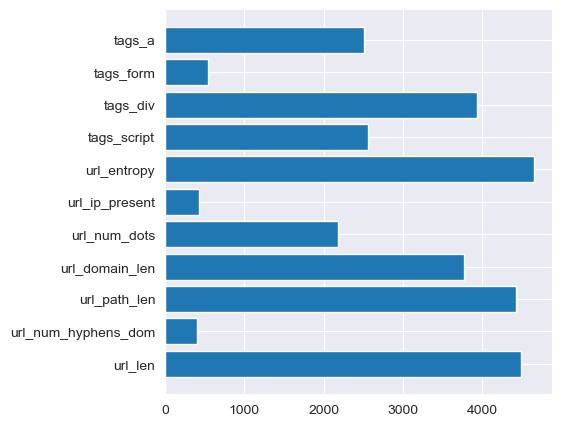

In [60]:
# 변수 중요도 시각화
plt.figure(figsize=(5, 5))
plt.barh(y=list(x), width=model.best_estimator_.feature_importances_)
plt.show()

- url_entropy와 url_path_len, url_len, url_domain_len이 가장 중요한 변수임을 확인할 수 있었다.

#### 최종 예측 모델 성능 평가 지표 시각화

Logistic Regression 0.932
Random Forest 0.962
XgBoost 0.962
LightGBM 0.967
Voting 0.964
hypertune_lightGBM 0.97


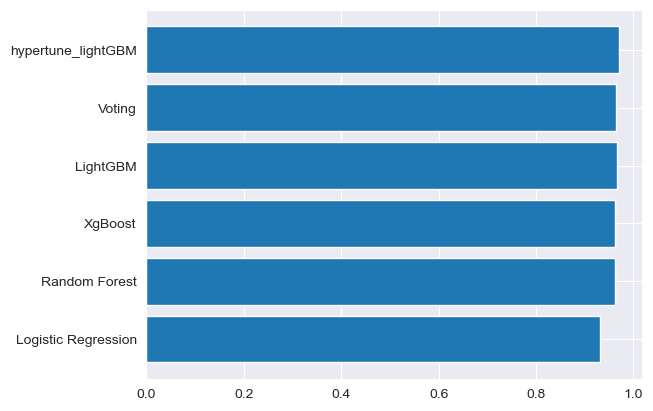

In [61]:
print('=' * 40)
for m_name, score in result.items():
    print(m_name, score.round(3))
print('=' * 40)

plt.barh(list(result.keys()), result.values())
plt.show()

#### 예측하기

In [62]:
y_pred = model.predict(x_test)

In [63]:
# 성능평가
print("학습 데이터 성능: ", model.score(x_train, y_train))
print("테스트 데이터 성능: ", accuracy_score(y_test, y_pred))

학습 데이터 성능:  1.0
테스트 데이터 성능:  0.9623655913978495


In [65]:
print("테스트 데이터 성능 confusion matrix: ")
print(confusion_matrix(y_test, y_pred))

테스트 데이터 성능 confusion matrix: 
[[134   8]
 [  6 224]]


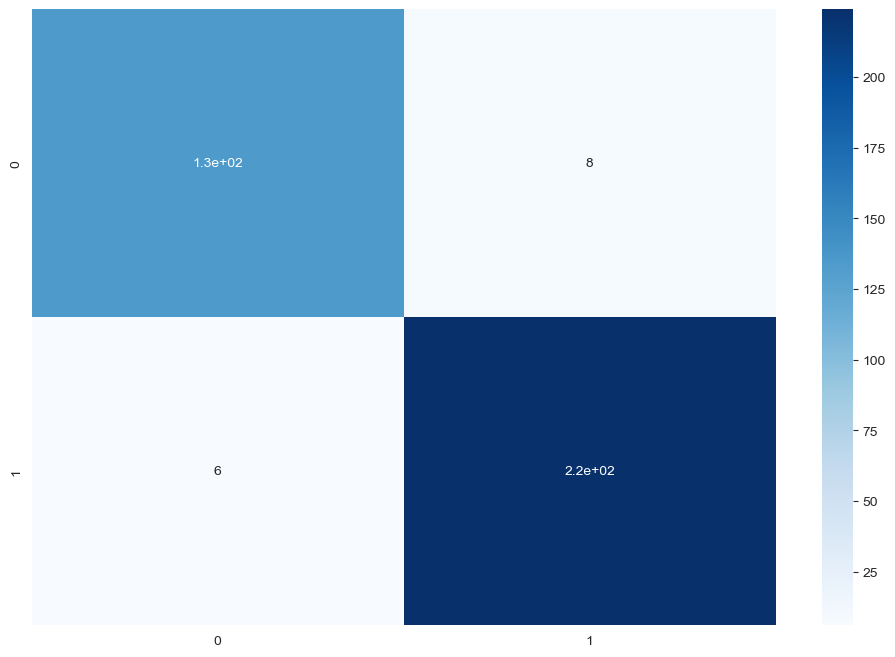

In [66]:
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(
    confusion_matrix(y_test, y_pred), cmap='Blues', annot=True
)
plt.show()